## 소프트맥스 회귀로 MNIST 데이터 분류하기

MNIST 데이터는 28 픽셀 * 28 픽셀 = 784 픽셀을 가지고 있다. 

#### 토치비전(torchvision) 소개하기
- 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [6]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하다면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") #GPU 사용 가능하면 사용하고 아니면 cpu 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [8]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [9]:
#하이퍼 파라미터 선언
training_epochs = 15
batch_size = 100

In [10]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/home/gitlabmaster/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

In [13]:
print(data_loader)

In [14]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

In [15]:
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [16]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.534912467
Epoch: 0002 cost = 0.359308630
Epoch: 0003 cost = 0.331088215
Epoch: 0004 cost = 0.316574216
Epoch: 0005 cost = 0.307130307
Epoch: 0006 cost = 0.300207853
Epoch: 0007 cost = 0.294897288
Epoch: 0008 cost = 0.290830463
Epoch: 0009 cost = 0.287419587
Epoch: 0010 cost = 0.284589082
Epoch: 0011 cost = 0.281816244
Epoch: 0012 cost = 0.279919684
Epoch: 0013 cost = 0.277836829
Epoch: 0014 cost = 0.276022315
Epoch: 0015 cost = 0.274443209
Learning finished


Accuracy: 0.8867999911308289
Label:  8
Prediction:  3


/home/gitlabmaster/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/gitlabmaster/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


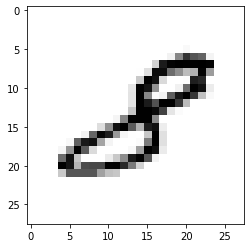

In [17]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

# 인공 신경망

## 머신 러닝 용어 이해하기

#### 머신 러닝 모델의 평가
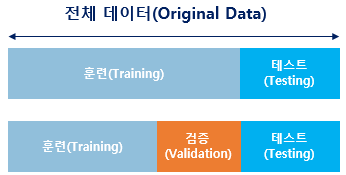
- 검증용 데이터는 모델의 성능을 평가하기 위한 용도가 아니라 모델의 성능을 조정-하기 위한 용도
- 하이퍼 파라미터 : 값에 따라서 모델의 성능에 영향을 주는 매개변수 ex) 은닉층의 수, 뉴런의 수, 드롭아웃 비율 등
- 매개 변수 : 가중치와 편향 같은 학습을 통해 바귀어져가는 변수
매개 변수와 하이퍼 파라미터의 가장 큰 차이는 하이퍼파라미터는 사용자가 직접 정해줄 수 있는 변수라는 점입니다. 

#### 단층 퍼셉트론

In [26]:
def AND_gate(x1, x2):
    w1 = 0.5
    w2 = 0.5
    b = -0.7
    result = x1 * w1 + x2 * w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [28]:
AND_gate(0, 0), AND_gate(0, 1), AND_gate(1, 0), AND_gate(1, 1)


(0, 0, 0, 1)

In [29]:
def NAND_gate(x1, x2):
    w1=-0.5
    w2=-0.5
    b=0.7
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [30]:
NAND_gate(0, 0), NAND_gate(0, 1), NAND_gate(1, 0), NAND_gate(1, 1)

(1, 1, 1, 0)

In [31]:
def OR_gate(x1, x2):
    w1=0.6
    w2=0.6
    b=-0.5
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1

In [32]:
OR_gate(0, 0), OR_gate(0, 1), OR_gate(1, 0), OR_gate(1, 1)

(0, 1, 1, 1)

여기까지의 함수 구현만으로는 한계가 존재합니다. 따라서 이를 해결하기 위한 방법이 필요하다.

## XOR 문제 - 단층 퍼셉트론 구현하기
- 파이토치로 단층 퍼셉트로 구현하기

In [34]:
import torch

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [37]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [40]:
linear = nn.Linear(2, 1, bias = True)
sigmoid = nn.Sigmoid()
model = nn.Sequential(linear, sigmoid).to(device)

In [44]:
#비용 함수와 옵티마이저
criterion = torch.nn.BCELoss().to(device)
optimzier = torch.optim.SGD(model.parameters(), lr = 1)

In [47]:
#10,001번의 에포크 수행. 0번 에포크부터 10,000번 에포크까지.
for step in range(10001): 
    optimizer.zero_grad()
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    if step % 100 == 0: # 100번째 에포크마다 비용 출력
        print(step, cost.item())

0 0.7433513402938843
100 0.7433513402938843
200 0.7433513402938843
300 0.7433513402938843
400 0.7433513402938843
500 0.7433513402938843
600 0.7433513402938843
700 0.7433513402938843
800 0.7433513402938843
900 0.7433513402938843
1000 0.7433513402938843
1100 0.7433513402938843
1200 0.7433513402938843
1300 0.7433513402938843
1400 0.7433513402938843
1500 0.7433513402938843
1600 0.7433513402938843
1700 0.7433513402938843
1800 0.7433513402938843
1900 0.7433513402938843
2000 0.7433513402938843
2100 0.7433513402938843
2200 0.7433513402938843
2300 0.7433513402938843
2400 0.7433513402938843
2500 0.7433513402938843
2600 0.7433513402938843
2700 0.7433513402938843
2800 0.7433513402938843
2900 0.7433513402938843
3000 0.7433513402938843
3100 0.7433513402938843
3200 0.7433513402938843
3300 0.7433513402938843
3400 0.7433513402938843
3500 0.7433513402938843
3600 0.7433513402938843
3700 0.7433513402938843
3800 0.7433513402938843
3900 0.7433513402938843
4000 0.7433513402938843
4100 0.7433513402938843
4200

In [48]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

모델의 출력값(Hypothesis):  [[0.61287934]
 [0.61397755]
 [0.68493944]
 [0.68593794]]
모델의 예측값(Predicted):  [[1.]
 [1.]
 [1.]
 [1.]]
실제값(Y):  [[0.]
 [1.]
 [1.]
 [0.]]
정확도(Accuracy):  0.5
